In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import os

# Add src to path
sys.path.append(os.path.join('..', 'src'))
from src.data.text_cleaner import TextCleaner

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")

In [2]:
def load_processed_data():
    """Load all processed data files"""
    data_dir = Path('../data/processed')
    
    results = {}
    
    # Load chunking results
    for strategy in ['fixed', 'sentence', 'semantic']:
        chunk_file = data_dir / f'chunks_{strategy}.json'
        if chunk_file.exists():
            with open(chunk_file, 'r') as f:
                results[strategy] = json.load(f)
    
    # Load statistics
    stats_file = data_dir / 'processing_stats.json'
    if stats_file.exists():
        with open(stats_file, 'r') as f:
            results['stats'] = json.load(f)
    
    # Load raw data
    raw_file = Path('../data/raw/britannica_raw.json')
    if raw_file.exists():
        with open(raw_file, 'r') as f:
            results['raw'] = json.load(f)
    
    return results

In [3]:
def analyze_chunk_distribution(data):
    """Analyze chunk size distribution across strategies"""
    print("📊 CHUNK SIZE DISTRIBUTION ANALYSIS")
    print("=" * 50)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for idx, strategy in enumerate(['fixed', 'sentence', 'semantic']):
        if strategy in data:
            chunks = data[strategy]
            sizes = [chunk['chunk_size'] for chunk in chunks]
            
            # Plot histogram
            axes[idx].hist(sizes, bins=20, alpha=0.7, color=sns.color_palette()[idx])
            axes[idx].set_title(f'{strategy.title()} Chunking')
            axes[idx].set_xlabel('Chunk Size (tokens)')
            axes[idx].set_ylabel('Frequency')
            
            # Add statistics
            mean_size = sum(sizes) / len(sizes)
            axes[idx].axvline(mean_size, color='red', linestyle='--', label=f'Mean: {mean_size:.1f}')
            axes[idx].legend()
            
            print(f"{strategy.upper()}:")
            print(f"  Total chunks: {len(chunks)}")
            print(f"  Mean size: {mean_size:.1f} tokens")
            print(f"  Min size: {min(sizes)} tokens")
            print(f"  Max size: {max(sizes)} tokens")
            print(f"  Std dev: {(sum((x - mean_size)**2 for x in sizes) / len(sizes))**0.5:.1f}")
            print()
    
    plt.tight_layout()
    plt.savefig('../docs/chunk_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

In [4]:
def analyze_content_coverage(data):
    """Analyze content coverage by section"""
    print("🗂️ CONTENT COVERAGE ANALYSIS")
    print("=" * 50)
    
    if 'fixed' not in data:
        print("No processed data found!")
        return
    
    chunks = data['fixed']
    
    # Count chunks by section
    section_counts = {}
    section_tokens = {}
    
    for chunk in chunks:
        section = chunk['section']
        if section not in section_counts:
            section_counts[section] = 0
            section_tokens[section] = 0
        
        section_counts[section] += 1
        section_tokens[section] += chunk['chunk_size']
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Chunks per section
    sections = list(section_counts.keys())
    counts = list(section_counts.values())
    
    ax1.bar(range(len(sections)), counts)
    ax1.set_xticks(range(len(sections)))
    ax1.set_xticklabels(sections, rotation=45, ha='right')
    ax1.set_title('Chunks per Section')
    ax1.set_ylabel('Number of Chunks')
    
    # Tokens per section
    tokens = list(section_tokens.values())
    ax2.bar(range(len(sections)), tokens)
    ax2.set_xticks(range(len(sections)))
    ax2.set_xticklabels(sections, rotation=45, ha='right')
    ax2.set_title('Tokens per Section')
    ax2.set_ylabel('Total Tokens')
    
    plt.tight_layout()
    plt.savefig('../docs/content_coverage.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print detailed stats
    total_chunks = sum(counts)
    total_tokens = sum(tokens)
    
    print(f"Total chunks: {total_chunks}")
    print(f"Total tokens: {total_tokens}")
    print(f"Average tokens per section: {total_tokens/len(sections):.1f}")
    print()
    
    print("Section breakdown:")
    for section, count, token_count in zip(sections, counts, tokens):
        print(f"  {section}: {count} chunks ({count/total_chunks*100:.1f}%), {token_count} tokens")


In [5]:
def analyze_text_quality(data):
    """Analyze text quality metrics"""
    print("✨ TEXT QUALITY ANALYSIS")
    print("=" * 50)
    
    if 'fixed' not in data:
        print("No processed data found!")
        return
    
    chunks = data['fixed']
    cleaner = TextCleaner()
    
    quality_metrics = {
        'total_chunks': len(chunks),
        'empty_chunks': 0,
        'short_chunks': 0,  # < 50 tokens
        'avg_sentence_length': 0,
        'special_chars': 0,
        'encoding_issues': 0
    }
    
    all_texts = []
    sentence_lengths = []
    
    for chunk in chunks:
        text = chunk['text']
        all_texts.append(text)
        
        # Check for empty chunks
        if not text.strip():
            quality_metrics['empty_chunks'] += 1
            continue
        
        # Check for short chunks
        if chunk['chunk_size'] < 50:
            quality_metrics['short_chunks'] += 1
        
        # Sentence analysis
        sentences = text.split('.')
        for sentence in sentences:
            if sentence.strip():
                sentence_lengths.append(len(sentence.split()))
        
        # Check for special characters
        if any(ord(c) > 127 for c in text):
            quality_metrics['special_chars'] += 1
        
        # Check for encoding issues
        if any(issue in text for issue in ['â€™', 'â€œ', 'â€']):
            quality_metrics['encoding_issues'] += 1
    
    if sentence_lengths:
        quality_metrics['avg_sentence_length'] = sum(sentence_lengths) / len(sentence_lengths)
    
    # Print results
    print("Quality Metrics:")
    print(f"  Total chunks: {quality_metrics['total_chunks']}")
    print(f"  Empty chunks: {quality_metrics['empty_chunks']} ({quality_metrics['empty_chunks']/quality_metrics['total_chunks']*100:.1f}%)")
    print(f"  Short chunks (<50 tokens): {quality_metrics['short_chunks']} ({quality_metrics['short_chunks']/quality_metrics['total_chunks']*100:.1f}%)")
    print(f"  Average sentence length: {quality_metrics['avg_sentence_length']:.1f} words")
    print(f"  Chunks with special chars: {quality_metrics['special_chars']} ({quality_metrics['special_chars']/quality_metrics['total_chunks']*100:.1f}%)")
    print(f"  Chunks with encoding issues: {quality_metrics['encoding_issues']} ({quality_metrics['encoding_issues']/quality_metrics['total_chunks']*100:.1f}%)")


In [6]:
def show_sample_chunks(data):
    """Show sample chunks from each strategy"""
    print("📝 SAMPLE CHUNKS")
    print("=" * 50)
    
    for strategy in ['fixed', 'sentence', 'semantic']:
        if strategy in data:
            chunks = data[strategy]
            print(f"\n{strategy.upper()} CHUNKING SAMPLE:")
            print("-" * 30)
            
            # Show first chunk
            if chunks:
                sample = chunks[0]
                print(f"Chunk ID: {sample['chunk_id']}")
                print(f"Section: {sample['section']}")
                print(f"Size: {sample['chunk_size']} tokens")
                print(f"Text preview: {sample['text'][:200]}...")
                print()

In [7]:
def compare_chunking_strategies(data):
    """Compare different chunking strategies"""
    print("⚖️ CHUNKING STRATEGY COMPARISON")
    print("=" * 50)
    
    strategies = ['fixed', 'sentence', 'semantic']
    comparison_data = []
    
    for strategy in strategies:
        if strategy in data:
            chunks = data[strategy]
            sizes = [chunk['chunk_size'] for chunk in chunks]
            
            strategy_stats = {
                'Strategy': strategy.title(),
                'Total Chunks': len(chunks),
                'Mean Size': sum(sizes) / len(sizes),
                'Std Dev': (sum((x - sum(sizes)/len(sizes))**2 for x in sizes) / len(sizes))**0.5,
                'Min Size': min(sizes),
                'Max Size': max(sizes)
            }
            comparison_data.append(strategy_stats)
    
    # Create comparison table
    df = pd.DataFrame(comparison_data)
    print(df.to_string(index=False, float_format='%.1f'))
    
    # Recommendations
    print("\n🎯 RECOMMENDATIONS:")
    print("- Fixed chunking: Best for consistent embedding performance")
    print("- Sentence chunking: Best balance of consistency and semantic coherence")
    print("- Semantic chunking: Best for topic-focused retrieval")
    
    return df

In [8]:
def validate_metadata_quality(data):
    """Validate metadata completeness and quality"""
    print("🏷️ METADATA QUALITY VALIDATION")
    print("=" * 50)
    
    if 'fixed' not in data:
        print("No processed data found!")
        return
    
    chunks = data['fixed']
    
    # Check metadata completeness
    required_fields = ['text', 'metadata', 'chunk_id', 'source_url', 'section']
    optional_fields = ['subsection', 'chunk_index', 'chunk_size']
    
    missing_required = {field: 0 for field in required_fields}
    missing_optional = {field: 0 for field in optional_fields}
    
    # URL validation
    valid_urls = 0
    unique_sections = set()
    unique_subsections = set()
    
    for chunk in chunks:
        # Check required fields
        for field in required_fields:
            if field not in chunk or not chunk[field]:
                missing_required[field] += 1
        
        # Check optional fields
        for field in optional_fields:
            if field not in chunk:
                missing_optional[field] += 1
        
        # URL validation
        if 'source_url' in chunk and chunk['source_url'].startswith('http'):
            valid_urls += 1
        
        # Collect unique values
        if 'section' in chunk:
            unique_sections.add(chunk['section'])
        if 'subsection' in chunk and chunk['subsection']:
            unique_subsections.add(chunk['subsection'])
    
    print("Required Field Completeness:")
    for field, missing in missing_required.items():
        completion = (len(chunks) - missing) / len(chunks) * 100
        print(f"  {field}: {completion:.1f}% complete ({missing} missing)")
    
    print(f"\nOptional Field Availability:")
    for field, missing in missing_optional.items():
        available = (len(chunks) - missing) / len(chunks) * 100
        print(f"  {field}: {available:.1f}% available")
    
    print(f"\nMetadata Statistics:")
    print(f"  Valid URLs: {valid_urls}/{len(chunks)} ({valid_urls/len(chunks)*100:.1f}%)")
    print(f"  Unique sections: {len(unique_sections)}")
    print(f"  Unique subsections: {len(unique_subsections)}")
    print(f"  Sections: {sorted(unique_sections)}")

In [9]:
def export_validation_report(data):
    """Export a comprehensive validation report"""
    print("📄 EXPORTING VALIDATION REPORT")
    print("=" * 50)
    
    report = {
        'validation_timestamp': pd.Timestamp.now().isoformat(),
        'data_summary': {},
        'quality_metrics': {},
        'recommendations': []
    }
    
    # Data summary
    for strategy in ['fixed', 'sentence', 'semantic']:
        if strategy in data:
            chunks = data[strategy]
            sizes = [chunk['chunk_size'] for chunk in chunks]
            
            report['data_summary'][strategy] = {
                'total_chunks': len(chunks),
                'mean_size': sum(sizes) / len(sizes),
                'std_dev': (sum((x - sum(sizes)/len(sizes))**2 for x in sizes) / len(sizes))**0.5,
                'min_size': min(sizes),
                'max_size': max(sizes)
            }
    
    # Quality metrics
    if 'fixed' in data:
        chunks = data['fixed']
        empty_chunks = sum(1 for chunk in chunks if not chunk['text'].strip())
        short_chunks = sum(1 for chunk in chunks if chunk['chunk_size'] < 50)
        
        report['quality_metrics'] = {
            'total_chunks': len(chunks),
            'empty_chunks': empty_chunks,
            'short_chunks': short_chunks,
            'quality_score': (1 - (empty_chunks + short_chunks) / len(chunks)) * 100
        }
    
    # Recommendations
    if 'stats' in data:
        stats = data['stats']
        
        # Recommend best strategy based on consistency
        consistency_scores = {}
        for strategy, strategy_stats in stats.items():
            if 'avg_chunk_size' in strategy_stats:
                # Lower std dev relative to mean = higher consistency
                consistency = strategy_stats['avg_chunk_size'] / (strategy_stats.get('std_dev', 1) + 1)
                consistency_scores[strategy] = consistency
        
        if consistency_scores:
            best_strategy = max(consistency_scores.keys(), key=lambda x: consistency_scores[x])
            report['recommendations'].append(f"Most consistent chunking: {best_strategy}")
    
    # Save report
    os.makedirs('../docs', exist_ok=True)
    with open('../docs/validation_report.json', 'w') as f:
        json.dump(report, f, indent=2)
    
    print(f"✅ Validation report saved to: ../docs/validation_report.json")
    print(f"📊 Quality score: {report['quality_metrics'].get('quality_score', 0):.1f}%")

In [10]:
print("=" * 60)
print("🔍 FRANCE RAG PIPELINE - DATA VALIDATION")
print("=" * 60)

# Load data
print("📁 Loading processed data...")
data = load_processed_data()

if not data:
    print("❌ No processed data found! Please run data processing first.")

print(f"✅ Loaded data with {len(data)} components")

🔍 FRANCE RAG PIPELINE - DATA VALIDATION
📁 Loading processed data...
✅ Loaded data with 5 components


📊 CHUNK SIZE DISTRIBUTION ANALYSIS
FIXED:
  Total chunks: 70
  Mean size: 363.4 tokens
  Min size: 27 tokens
  Max size: 512 tokens
  Std dev: 176.6

SENTENCE:
  Total chunks: 81
  Mean size: 357.3 tokens
  Min size: 27 tokens
  Max size: 576 tokens
  Std dev: 171.8

SEMANTIC:
  Total chunks: 31
  Mean size: 757.7 tokens
  Min size: 27 tokens
  Max size: 2913 tokens
  Std dev: 973.6



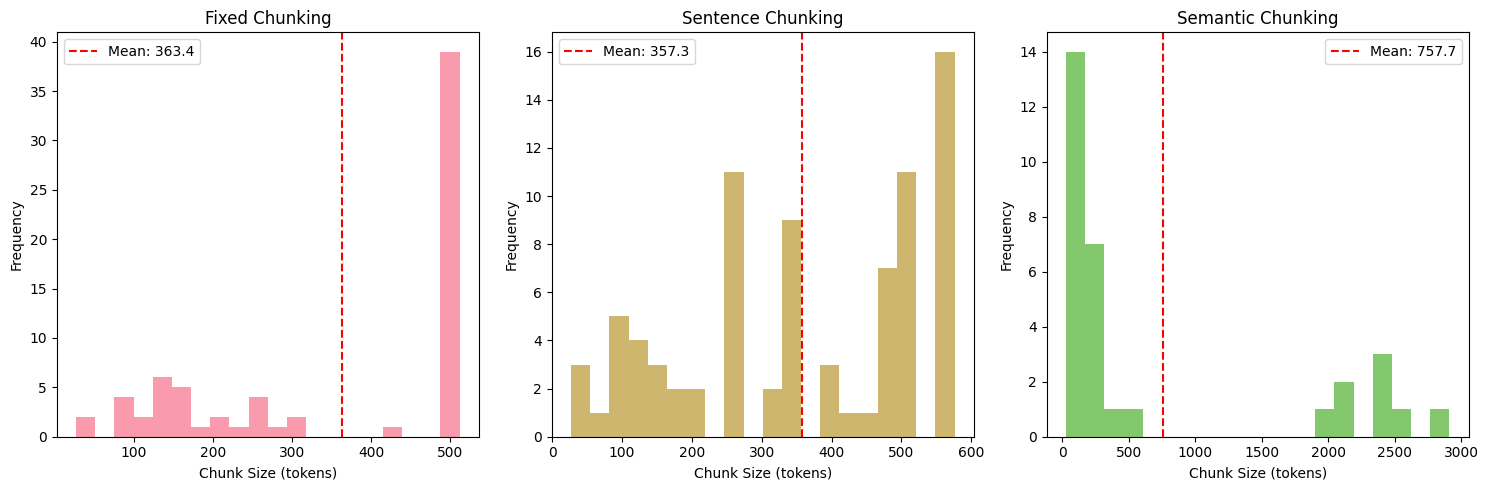

In [11]:
analyze_chunk_distribution(data)

🗂️ CONTENT COVERAGE ANALYSIS


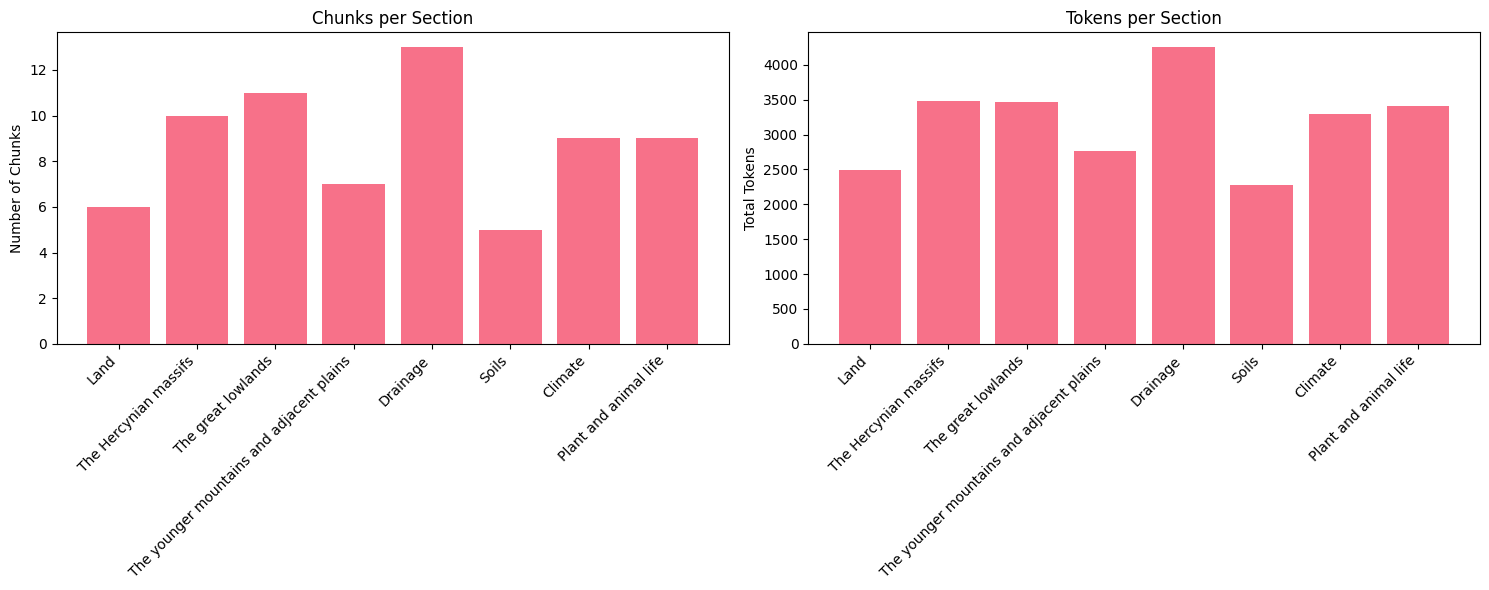

Total chunks: 70
Total tokens: 25438
Average tokens per section: 3179.8

Section breakdown:
  Land: 6 chunks (8.6%), 2494 tokens
  The Hercynian massifs: 10 chunks (14.3%), 3477 tokens
  The great lowlands: 11 chunks (15.7%), 3467 tokens
  The younger mountains and adjacent plains: 7 chunks (10.0%), 2759 tokens
  Drainage: 13 chunks (18.6%), 4253 tokens
  Soils: 5 chunks (7.1%), 2280 tokens
  Climate: 9 chunks (12.9%), 3294 tokens
  Plant and animal life: 9 chunks (12.9%), 3414 tokens


In [12]:
analyze_content_coverage(data)

In [13]:
analyze_text_quality(data)

✨ TEXT QUALITY ANALYSIS
Quality Metrics:
  Total chunks: 70
  Empty chunks: 0 (0.0%)
  Short chunks (<50 tokens): 2 (2.9%)
  Average sentence length: 32.9 words
  Chunks with special chars: 0 (0.0%)
  Chunks with encoding issues: 0 (0.0%)


In [14]:
show_sample_chunks(data)

📝 SAMPLE CHUNKS

FIXED CHUNKING SAMPLE:
------------------------------
Chunk ID: Land_main_0
Section: Land
Size: 512 tokens
Text preview: France Table of Contents Introduction Quick Facts Land Relief The Hercynian massifs The Ardennes The Vosges The Massif Central The Massif Armoricain The great lowlands The Paris Basin The Flanders Pla...


SENTENCE CHUNKING SAMPLE:
------------------------------
Chunk ID: Land_main_0
Section: Land
Size: 344 tokens
Text preview: France Table of Contents Introduction  Quick Facts Land Relief The Hercynian massifs The Ardennes The Vosges The Massif Central The Massif Armoricain The great lowlands The Paris Basin The Flanders Pl...


SEMANTIC CHUNKING SAMPLE:
------------------------------
Chunk ID: Land_main_0
Section: Land
Size: 2040 tokens
Text preview: France Table of Contents Introduction  Quick Facts Land Relief The Hercynian massifs The Ardennes The Vosges The Massif Central The Massif Armoricain The great lowlands The Paris Basin The Flanders Pl.

In [15]:
compare_chunking_strategies(data)

⚖️ CHUNKING STRATEGY COMPARISON
Strategy  Total Chunks  Mean Size  Std Dev  Min Size  Max Size
   Fixed            70      363.4    176.6        27       512
Sentence            81      357.3    171.8        27       576
Semantic            31      757.7    973.6        27      2913

🎯 RECOMMENDATIONS:
- Fixed chunking: Best for consistent embedding performance
- Sentence chunking: Best balance of consistency and semantic coherence
- Semantic chunking: Best for topic-focused retrieval


,Strategy,Total Chunks,Mean Size,Std Dev,Min Size,Max Size
0,Fixed,70,363.400000,176.557267,27,512
1,Sentence,81,357.271605,171.759020,27,576
2,Semantic,31,757.677419,973.610884,27,2913


In [16]:
validate_metadata_quality(data)

🏷️ METADATA QUALITY VALIDATION
Required Field Completeness:
  text: 100.0% complete (0 missing)
  metadata: 100.0% complete (0 missing)
  chunk_id: 100.0% complete (0 missing)
  source_url: 100.0% complete (0 missing)
  section: 100.0% complete (0 missing)

Optional Field Availability:
  subsection: 100.0% available
  chunk_index: 100.0% available
  chunk_size: 100.0% available

Metadata Statistics:
  Valid URLs: 70/70 (100.0%)
  Unique sections: 8
  Unique subsections: 23
  Sections: ['Climate', 'Drainage', 'Land', 'Plant and animal life', 'Soils', 'The Hercynian massifs', 'The great lowlands', 'The younger mountains and adjacent plains']


In [17]:
export_validation_report(data)

📄 EXPORTING VALIDATION REPORT
✅ Validation report saved to: ../docs/validation_report.json
📊 Quality score: 97.1%
